In [ ]:
%matplotlib inline


# Cherry Evaluation


**Author**: Wes Havener

This uses the data collected on 11/2/2022 and has several models to choose from:

- model trained on 11_2 data using gradient descent optimizer
- model trained on 11_2 data using ADAM optimizer
- previous model (trained using gradient descent optimizer)


## Install necessary software and import python libraries

In [ ]:
pip install fiftyone

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import fiftyone as fo
from fiftyone import ViewField as F

Migrating database to v0.17.2


INFO:fiftyone.migrations.runner:Migrating database to v0.17.2


## Load Data

Upload a presorted data set



In [ ]:
!git clone https://github.com/weshavener/cherry_classification.git

Cloning into 'cherry_classification'...
remote: Enumerating objects: 4869, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4869 (delta 0), reused 3 (delta 0), pack-reused 4865
Receiving objects: 100% (4869/4869), 273.91 MiB | 25.62 MiB/s, done.


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

# for this evaluation, use the unmodifided training images
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(128),
        #transforms.RandomAffine(degrees=(0, 20), translate=(0, 0), scale=(0.85, 1.15)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cherry_classification/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=200,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the model

uncomment the model you want to run here


- model trained on 11_2 data using gradient descent optimizer
- model trained on 11_2 data using ADAM optimizer
- previous model (trained using gradient descent optimizer)



In [ ]:
model_path = '/content/cherry_classification/models/classification_11_2022_all_data_adam.pt'
#model_path = '/content/cherry_classification/models/classification_11_2022_all_data_sgd.pt'
#model_path = '/content/cherry_classification/models/classification_old.pt'


In [ ]:

weights = torch.load(model_path)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

# get a resnet50 model definition
# set the num classes to 2 instead of the default value
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.load_state_dict(weights)


model_ft.to(device)
model_ft.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

It would be nice to view the dataset with fiftyone, but that is still a work in progress right now

## Run data through model
Run the images through the model and get data for the visualization tool fifytone

In [ ]:

samples = []

def add_to_fiddy(input, label, ouput, pred, conf, confs, img_path, dataset_type):
    global samples

    print(label, ouput, pred, conf, confs, img_path)
    sample = fo.Sample(filepath=img_path[0],  tags=[dataset_type])

    classes = ['cherry_clean', 'cherry_pit']

    sample["ground_truth"] = fo.Classification(label=classes[label])
    sample["prediction"] = fo.Classification(label=classes[pred], confidence=conf)

    samples.append(sample)


def evaluate_model(model, num_images, dataset_type):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    m = nn.Softmax(dim=1)

    with torch.no_grad():

        dl = dataloaders[dataset_type]
        for i, (inputs, labels) in enumerate(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            batch_len = inputs.size()[0]

            images = dl.dataset.imgs[i*batch_len:(i+1)*batch_len]

            #print(inputs)
            outputs = model(inputs)
            #print('\n\n')
            #print(outputs)
            #print('\n\n')
            confs = m(outputs)
            index, preds = torch.max(confs, 1)



            #print(outputs)

            for j in range(inputs.size()[0]):
                #print(inputs[j], labels[j], outputs[j], preds[j], index[j], confs[j], images[j], dataset_type)
                add_to_fiddy(inputs[j], labels[j], outputs[j], preds[j], index[j], confs[j], images[j], dataset_type)

                images_so_far += 1
                # ax = plt.subplot(num_images//2, 2, images_so_far)
                # ax.axis('off')
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                # imshow(inputs.cpu().data[j])



                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)






In [ ]:
evaluate_model(model_ft, 10000, dataset_type='val')
evaluate_model(model_ft, 10000, dataset_type='train')

dataset = fo.Dataset() # use this instead of a specific name to gaurentee a unique databse is created
#fo.Dataset("cherry-classification-dataset")

# this is used if a dataset already exists
#dataset = fo.load_dataset("cherry-classification-dataset")
#dataset.clear()

# add samples to dataset
dataset.add_samples(samples)


tensor(0, device='cuda:0') tensor([ 3.3694, -3.1612], device='cuda:0') tensor(0, device='cuda:0') tensor(0.9985, device='cuda:0') tensor([0.9985, 0.0015], device='cuda:0') ('cherry_classification/data/val/cherry_clean/cherry_1004.png', 0)
tensor(0, device='cuda:0') tensor([ 2.1129, -1.9849], device='cuda:0') tensor(0, device='cuda:0') tensor(0.9837, device='cuda:0') tensor([0.9837, 0.0163], device='cuda:0') ('cherry_classification/data/val/cherry_clean/cherry_1006.png', 0)
tensor(0, device='cuda:0') tensor([ 1.6572, -1.5605], device='cuda:0') tensor(0, device='cuda:0') tensor(0.9615, device='cuda:0') tensor([0.9615, 0.0385], device='cuda:0') ('cherry_classification/data/val/cherry_clean/cherry_1012.png', 0)
tensor(1, device='cuda:0') tensor([-1.3875,  1.3820], device='cuda:0') tensor(1, device='cuda:0') tensor(0.9410, device='cuda:0') tensor([0.0590, 0.9410], device='cuda:0') ('cherry_classification/data/val/cherry_clean/cherry_1013.png', 0)
tensor(0, device='cuda:0') tensor([ 2.7811, 

INFO:eta.core.utils: 100% |███████████████| 4902/4902 [5.6s elapsed, 0s remaining, 876.9 samples/s]      


['636533ede99e0e62fb909453',
 '636533ede99e0e62fb909456',
 '636533ede99e0e62fb909457',
 '636533ede99e0e62fb90945c',
 '636533ede99e0e62fb90945d',
 '636533ede99e0e62fb90945e',
 '636533ede99e0e62fb90945f',
 '636533ede99e0e62fb909468',
 '636533ede99e0e62fb909469',
 '636533ede99e0e62fb90946a',
 '636533ede99e0e62fb90946b',
 '636533ede99e0e62fb90946c',
 '636533ede99e0e62fb90946d',
 '636533ede99e0e62fb90946e',
 '636533ede99e0e62fb90946f',
 '636533ede99e0e62fb909480',
 '636533ede99e0e62fb909481',
 '636533ede99e0e62fb909482',
 '636533ede99e0e62fb909483',
 '636533ede99e0e62fb909484',
 '636533ede99e0e62fb909485',
 '636533ede99e0e62fb909486',
 '636533ede99e0e62fb909487',
 '636533ede99e0e62fb909488',
 '636533ede99e0e62fb909489',
 '636533ede99e0e62fb90948a',
 '636533ede99e0e62fb90948b',
 '636533ede99e0e62fb90948c',
 '636533ede99e0e62fb90948d',
 '636533ede99e0e62fb90948e',
 '636533ede99e0e62fb90948f',
 '636533ede99e0e62fb9094b0',
 '636533ede99e0e62fb9094b1',
 '636533ede99e0e62fb9094b2',
 '636533ede99e

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Visualiza the results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


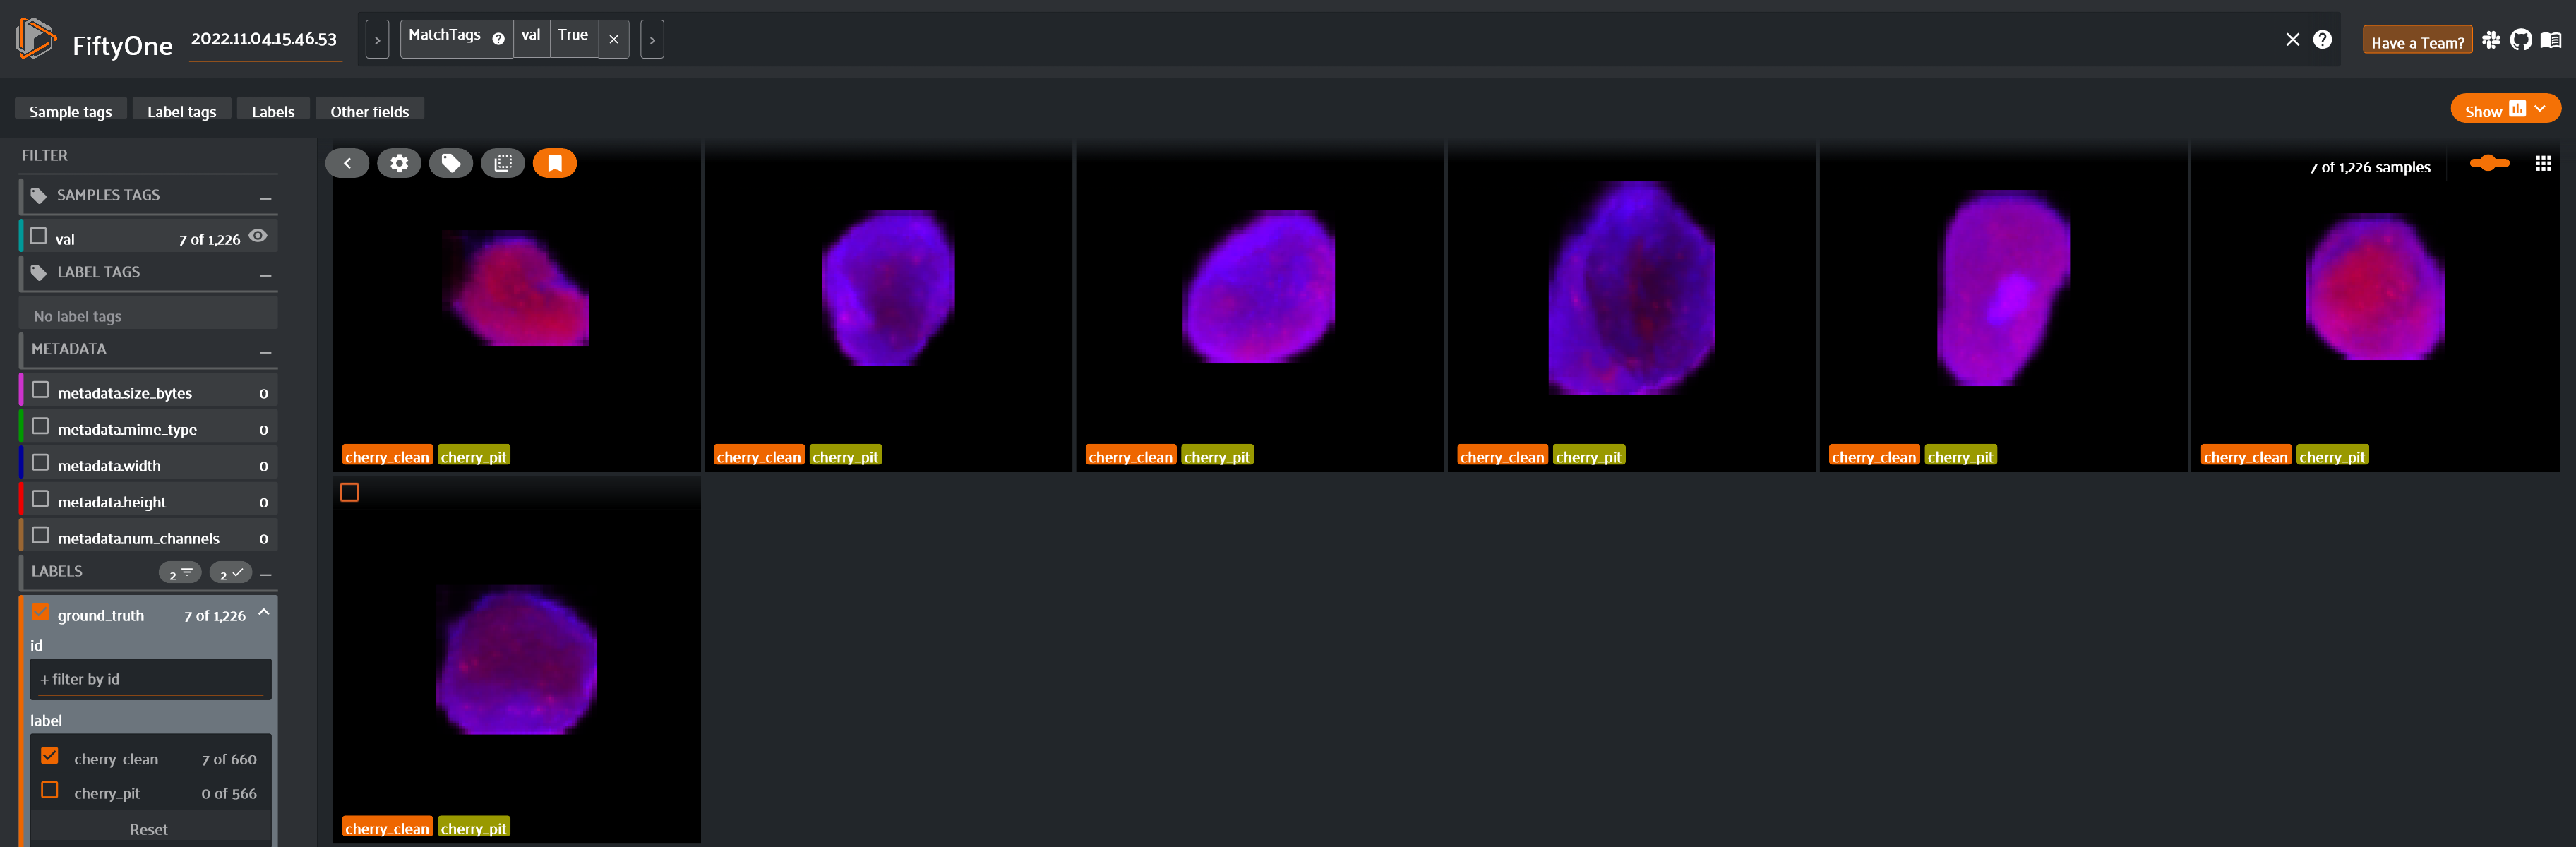

<IPython.core.display.Javascript object>

In [ ]:

#fo.load_dataset()
#fo.close_app()
session = fo.launch_app(dataset)

In [ ]:

# Evaluate the objects in the `predictions` field with respect to the
# objects in the `ground_truth` field

validation_view = dataset.match_tags("val")
validation_results = validation_view.evaluate_classifications(
    "prediction",
)

train_view = dataset.match_tags("train")
train_results = train_view.evaluate_classifications(
    "prediction",
)

all_view = dataset.match_tags(["train", "val"])
all_results = all_view.evaluate_classifications(
    "prediction",
)

print('validation set results:')
validation_results.print_report()
print('train set results:')
train_results.print_report()
print('all results:')
all_results.print_report()

validation set results:
              precision    recall  f1-score   support

cherry_clean       0.93      0.95      0.94       660
  cherry_pit       0.93      0.91      0.92       566

    accuracy                           0.93      1226
   macro avg       0.93      0.93      0.93      1226
weighted avg       0.93      0.93      0.93      1226

train set results:
              precision    recall  f1-score   support

cherry_clean       0.95      0.96      0.95      1978
  cherry_pit       0.95      0.94      0.95      1698

    accuracy                           0.95      3676
   macro avg       0.95      0.95      0.95      3676
weighted avg       0.95      0.95      0.95      3676

all results:
              precision    recall  f1-score   support

cherry_clean       0.94      0.96      0.95      2638
  cherry_pit       0.95      0.93      0.94      2264

    accuracy                           0.95      4902
   macro avg       0.95      0.94      0.95      4902
weighted avg      

# validiation data confusion matrix

This is the most relevant matrix



In [ ]:
plot_val = validation_results.plot_confusion_matrix(classes=['cherry_clean', 'cherry_pit'])
plot_val.show()

# Connect to session
session.plots.attach(plot_val)

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1782: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



### training data confusion matrix

note that for the old model, all data is new and can be considered validation data

In [ ]:
plot_train = train_results.plot_confusion_matrix(classes=['cherry_clean', 'cherry_pit'])
plot_train.show()

# Connect to session
session.plots.attach(plot_train)

### all data confusion matrix



In [ ]:
plot_all = all_results.plot_confusion_matrix(classes=['cherry_clean', 'cherry_pit'])
plot_all.show()

# Connect to session
session.plots.attach(plot_all)

In [ ]:
plot_val.freeze()
plot_train.freeze()
plot_all.freeze()

In [ ]:
session.view = all_view